In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import re
from glob import glob
import pandas as pd
from mammo_utils import read_pgm

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Annotation Data

In [5]:
# import the annotation data using code from existing kaggle kernel
all_cases_df = pd.read_table('data/Info.txt', delimiter=' ')
all_cases_df = all_cases_df[all_cases_df.columns[:-1]] # drop last column
all_cases_df.head(20)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
5,mdb005,F,CIRC,B,500.0,168.0,26.0
6,mdb006,F,NORM,NaN,NaN,NaN,NaN
7,mdb007,G,NORM,NaN,NaN,NaN,NaN
8,mdb008,G,NORM,NaN,NaN,NaN,NaN
9,mdb009,F,NORM,NaN,NaN,NaN,NaN


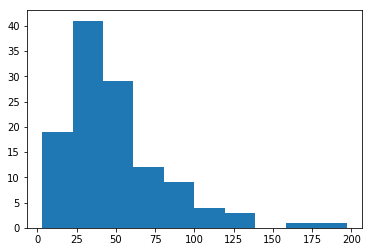

In [6]:
## Look at the sizes of radii
radii = all_cases_df.RADIUS
radii.dropna(inplace=True)
plt.hist(radii)
plt.show()

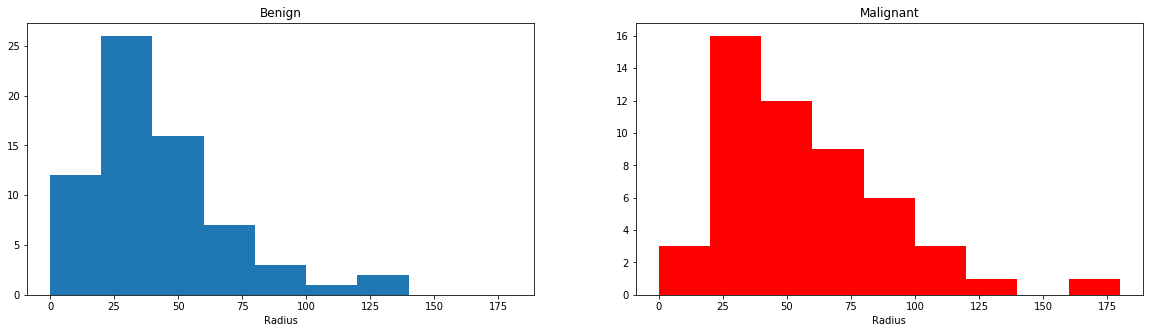

In [39]:
## Look at radii by severity
sev_radii = all_cases_df.loc[:,['RADIUS','SEVERITY']]
sev_radii.dropna(axis=0, how='any', inplace=True)
benign = sev_radii[sev_radii.SEVERITY == 'B']
malignant = sev_radii[sev_radii.SEVERITY == 'M']
f, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].hist(benign.RADIUS, bins=range(0,200,20))
ax[0].set_xlabel("Radius")
ax[0].set_title("Benign")
ax[1].hist(malignant.RADIUS, color="red",  bins=range(0,200,20))
ax[1].set_title("Malignant")
ax[1].set_xlabel("Radius")
plt.show()

## Read in PGM Data

## Look at some images

In [55]:
# draw image with location of center of abnormality
def draw_image(idx):
    plt.imshow(read_pgm(glob('data/pgms/*.pgm')[idx]))
    
    # account for horizontal flip of some images
    if idx % 2 == 0:
        x_loc = all_cases_df.X[idx]
    else:
        x_loc = 1024 - all_cases_df.X[idx]
    plt.plot([x_loc],[1024-all_cases_df.Y[idx]], 'ro')
    radius = str(all_cases_df.RADIUS[idx])
    plt.title("Radius:" + radius)

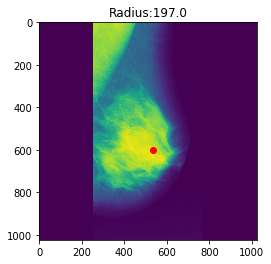

In [56]:
draw_image(0)

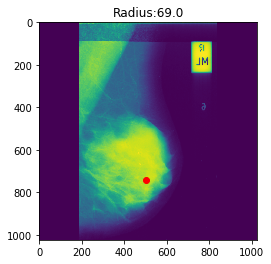

In [57]:
draw_image(1)

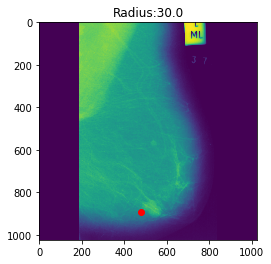

In [58]:
draw_image(4)

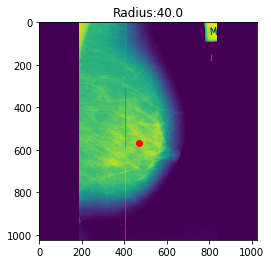

In [61]:
draw_image(12)

## Clean up the Annotation Data

In [62]:
## Clean up the data.
# Some images have multiple abnormalities, drop those and keep one row per image
all_cases_df.drop_duplicates(subset=['REFNUM'], keep='first', inplace=True)

# reindex it
all_cases_df.reset_index(inplace=True)
all_cases_df.shape

(322, 8)

In [63]:
# percentages by class
all_cases_df['CLASS'].value_counts(normalize=True)

NORM    0.642857
CALC    0.077640
CIRC    0.071429
ARCH    0.059006
SPIC    0.059006
ASYM    0.046584
MISC    0.043478
Name: CLASS, dtype: float64

In [64]:
# percentages by type
all_cases_df['SEVERITY'].value_counts(normalize=True)

B    0.556522
M    0.443478
Name: SEVERITY, dtype: float64

In [10]:
# info on the size of the abnormalities
print("Mean abnormality radius:",np.mean(radii))
print("Median abnormality radius:",np.median(radii))
print("Min abnormality radius:",np.min(radii))
print("Max abnormality radius:",np.max(radii))

Mean abnormality radius: 48.84873949579832
Median abnormality radius: 41.0
Min abnormality radius: 3.0
Max abnormality radius: 197.0


## Look at scans of various classes

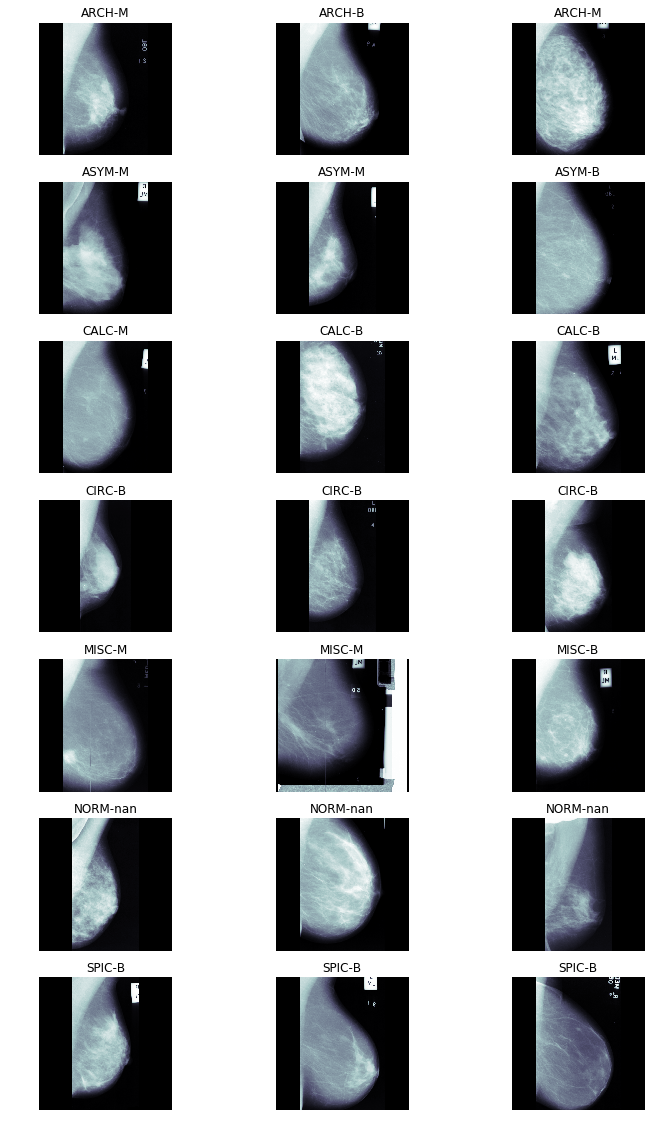

In [68]:
sample_count = 3
fig, m_axs = plt.subplots(len(all_cases_df['CLASS'].value_counts()), 3, figsize = (12, 20))
for c_axs, (c_cat, c_df) in zip(m_axs, all_cases_df.groupby('CLASS')):
    for c_ax, (_, c_row) in zip(c_axs, c_df.sample(sample_count).iterrows()):
        c_ax.imshow(read_pgm('data/pgms/' + c_row['REFNUM'] + '.pgm'), cmap = 'bone')
        c_ax.axis('off')
        c_ax.set_title('{CLASS}-{SEVERITY}'.format(**c_row))

## Low-Res Scans

In [69]:
# import the data
with h5py.File('data/all_mias_scans.h5') as scan_h5:
    bg_info = scan_h5['BG'][:]
    class_info = scan_h5['CLASS'][:]
    # low res scans
    scan_lr = scan_h5['scan'][:][:, ::16, ::16]

In [70]:
# process the labels into usable labels
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
class_le.fit(class_info)
class_vec = class_le.transform(class_info)

In [71]:
class_le.classes_

array([b'ARCH', b'ASYM', b'CALC', b'CIRC', b'MISC', b'NORM', b'SPIC'],
      dtype='|S4')

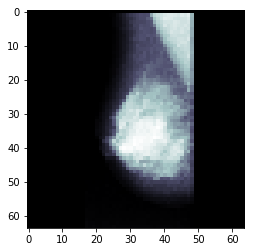

In [72]:
# look at a low res scan
plt.imshow(scan_lr[0], cmap = 'bone')

## Names

In [73]:
names = np.load(os.path.join("data","names.npy"))
names

array(['ARCH', 'ASYM', 'CALC', 'CIRC', 'MISC', 'NORM', 'SPIC'],
      dtype=object)